# Proof of concept notebook for the Frame Booster project
- Author: Kamil Barszczak
- Contact: kamilbarszczak62@gmail.com
- Project: https://github.com/kbarszczak/Frame_booster

In [1]:
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import pickle
import keras
import time
import cv2
import os

from keras import preprocessing
from keras import regularizers
from keras import activations
from keras import optimizers
from keras import callbacks
from keras import layers
from keras import losses
from keras import models

from tensorflow.keras import backend as K
from tensorflow.keras.applications.vgg16 import VGG16

In [2]:
data_base_path = 'E:/Data/Video_Frame_Interpolation/processed/med_motion'
data_creation_time = '1681975868'
model_base_path = 'E:/OneDrive - Akademia Górniczo-Hutnicza im. Stanisława Staszica w Krakowie/Programming/Labs/Frame_booster/models'
model_name = 'frame_booster'
width, height = 224, 128

## Load dataset

In [3]:
def load_data(base_path, creation_time, width, height):
    with open(os.path.join(base_path, f'x_train_{height}x{width}_{creation_time}.pickle'), 'rb') as file:
        x_train = pickle.load(file)
        
    with open(os.path.join(base_path, f'y_train_{height}x{width}_{creation_time}.pickle'), 'rb') as file:
        y_train = pickle.load(file)
        
    with open(os.path.join(base_path, f'x_test_{height}x{width}_{creation_time}.pickle'), 'rb') as file:
        x_test = pickle.load(file)
        
    with open(os.path.join(base_path, f'y_test_{height}x{width}_{creation_time}.pickle'), 'rb') as file:
        y_test = pickle.load(file)
        
    with open(os.path.join(base_path, f'x_valid_{height}x{width}_{creation_time}.pickle'), 'rb') as file:
        x_valid = pickle.load(file)
        
    with open(os.path.join(base_path, f'y_valid_{height}x{width}_{creation_time}.pickle'), 'rb') as file:
        y_valid = pickle.load(file)
        
    return (np.array(x_train)/255.0).astype('float32'), (np.array(x_test)/255.0).astype('float32'), (np.array(x_valid)/255.0).astype('float32'), (np.array(y_train)/255.0).astype('float32'), (np.array(y_test)/255.0).astype('float32'), (np.array(y_valid)/255.0).astype('float32')

In [4]:
x_train, x_test, x_valid, y_train, y_test, y_valid = load_data(
    data_base_path,
    data_creation_time,
    width, 
    height
)

In [5]:
print(f'Train size: {len(x_train)}')
print(f'Test size: {len(x_test)}')
print(f'Validation size: {len(x_valid)}')

Train size: 918
Test size: 256
Validation size: 103


## Create loss functions

In [6]:
"""
The Perceptual Loss function is responsible for ...
"""
def perceptual_loss(y_true, y_pred):
    vgg = VGG16(include_top=False, input_shape=y_true.shape[1:])
    vgg.trainable = False
    for layer in vgg.layers:
        layer.trainable = False
    outputs_true = vgg(y_true)
    outputs_pred = vgg(y_pred)
    loss = 0
    for output_true, output_pred in zip(outputs_true, outputs_pred):
        loss += K.mean(K.square(output_true - output_pred))
    return K.mean(outputs_pred)


"""
The Color Loss function is responsible for ...
"""
def color_loss(y_true, y_pred):
    return K.sum(K.abs(y_true - y_pred)) / (width*height)


"""
The Gradient Loss function is responsible for ...
"""
def gradient_loss(y_true, y_pred):
    grad_true = tf.image.sobel_edges(y_true)
    grad_pred = tf.image.sobel_edges(y_pred)
    return K.mean(K.abs(grad_true - grad_pred))


"""
The PSNR function is responsible for ...
"""
def psnr(y_true, y_pred):
    mse = K.mean(K.square(y_true - y_pred))
    psnr = 10.0*K.log(1.0 / mse) / K.log(10.0)
    return -psnr


"""
The SSIM function is responsible for ...
"""
def ssim(y_true, y_pred):
    c1 = 0.01 ** 2
    c2 = 0.03 ** 2

    mu_true = K.mean(y_true)
    mu_pred = K.mean(y_pred)

    sigma_true = K.var(y_true)
    sigma_pred = K.var(y_pred)
    sigma_true_pred = K.mean(y_true * y_pred) - mu_true * mu_pred

    numerator = (2 * mu_true * mu_pred + c1) * (2 * sigma_true_pred + c2)
    denominator = (mu_true ** 2 + mu_pred ** 2 + c1) * (sigma_true + sigma_pred + c2)
    ssim = numerator / denominator

    return 1.0 - ssim

## Create model

In [7]:
"""
PyramidFeatureExtractor is a class that ...
"""
class PyramidFeatureExtractor(layers.Layer):
    def __init__(self, **kwargs):
        # initialize super class
        super(PyramidFeatureExtractor, self).__init__(**kwargs)
        
        # for pyramid creation
        self.downsample_avg = layers.AveragePooling2D((2, 2))
        
        # for feature extration (those layers are shared)
        self.cnn_1st_level = layers.Conv2D(16, (3, 3), activation='relu', padding='same')
        self.cnn_2nd_level = layers.Conv2D(32, (3, 3), activation='relu', padding='same', strides=(2, 2))
        self.cnn_3rd_level = layers.Conv2D(64, (3, 3), activation='relu', padding='same', strides=(2, 2))
        
        # concatenation layers
        self.concat_2nd_level = layers.Concatenate()
        self.concat_3rd_level = layers.Concatenate()
        self.concat_4th_level = layers.Concatenate()
        
    def get_config(self):
        config = super().get_config()
        config.update({
            "downsample_avg": self.downsample_avg,
            "cnn_1st_level": self.cnn_1st_level,
            "cnn_2nd_level": self.cnn_2nd_level,
            "cnn_3rd_level": self.cnn_3rd_level,
            "concat_2nd_level": self.concat_2nd_level,
            "concat_3rd_level": self.concat_3rd_level,
            "concat_4th_level": self.concat_4th_level,
        })
        return config

    def call(self, inputs):
        # pyramid
        input_1 = inputs
        input_2 = self.downsample_avg(input_1)
        input_3 = self.downsample_avg(input_2)
        input_4 = self.downsample_avg(input_3)
        
        # feature extraction & connection sharing
        input_1_1st_level = self.cnn_1st_level(input_1)
        input_2_2nd_level = self.cnn_1st_level(input_2)
        input_3_3rd_level = self.cnn_1st_level(input_3)
        input_4_4th_level = self.cnn_1st_level(input_4)
        
        input_1_2nd_level = self.cnn_2nd_level(input_1_1st_level)
        input_2_3rd_level = self.cnn_2nd_level(input_2_2nd_level)
        input_3_4th_level = self.cnn_2nd_level(input_3_3rd_level)
        
        input_1_3rd_level = self.cnn_3rd_level(input_1_2nd_level)
        input_2_4th_level = self.cnn_3rd_level(input_2_3rd_level)
        
        # concatenate each level
        concat_1st = input_1_1st_level
        concat_2nd = self.concat_2nd_level([input_1_2nd_level, input_2_2nd_level])
        concat_3rd = self.concat_3rd_level([input_1_3rd_level, input_2_3rd_level, input_3_3rd_level])
        concat_4th = self.concat_4th_level([input_2_4th_level, input_3_4th_level, input_4_4th_level])
        
        # return the outputs
        return [concat_1st, concat_2nd, concat_3rd, concat_4th]

In [8]:
"""
FlowEstimator is a class that ...
"""
class FlowEstimator(layers.Layer):
    def __init__(self, **kwargs):
        # initialize super class
        super(SimpleFusion, self).__init__(**kwargs)
        
    def get_config(self):
        config = super().get_config()
        config.update({
            "": None,
        })
        return config

    def call(self, inputs):
        return None

In [27]:
"""
SimpleFusion is a class that ...
"""
class SimpleFusion(layers.Layer):
    def __init__(self, **kwargs):
        # initialize super class
        super(SimpleFusion, self).__init__(**kwargs)
        
        self.cnn_1st_level_o = layers.Conv2D(3, (1, 1), activation='relu', padding='same')
        self.cnn_1st_level_1 = layers.Conv2D(16, (3, 3), activation='relu', padding='same')
        self.cnn_1st_level_2 = layers.Conv2D(16, (3, 3), activation='relu', padding='same')
        self.add_1st_level = layers.Add()
        
        self.up_2nd_level = layers.UpSampling2D((2, 2), interpolation='bicubic')
        self.cnn_2nd_level_2 = layers.Conv2D(16, (3, 3), activation='relu', padding='same')
        self.cnn_2nd_level_1 = layers.Conv2D(16, (3, 3), activation='relu', padding='same')
        self.add_2nd_level = layers.Add()
        
        self.up_3rd_level = layers.UpSampling2D((2, 2), interpolation='bicubic')
        self.cnn_3rd_level_2 = layers.Conv2D(48, (3, 3), activation='relu', padding='same')
        self.cnn_3rd_level_1 = layers.Conv2D(48, (3, 3), activation='relu', padding='same')
        self.add_3rd_level = layers.Add()
        
        self.up_4th_level = layers.UpSampling2D((2, 2), interpolation='bicubic')
        self.cnn_4th_level_2 = layers.Conv2D(112, (3, 3), activation='relu', padding='same')
        self.cnn_4th_level_1 = layers.Conv2D(112, (3, 3), activation='relu', padding='same')
        self.add_4th_level = layers.Add()
        
    def get_config(self):
        config = super().get_config()
        config.update({
            "cnn_1st_level_o": self.cnn_1st_level_o,
            "cnn_1st_level_1": self.cnn_1st_level_1,
            "cnn_1st_level_2": self.cnn_1st_level_2,
            "add_1st_level": self.add_1st_level,
            "up_2nd_level": self.up_2nd_level,
            "cnn_2nd_level_2": self.cnn_2nd_level_2,
            "cnn_2nd_level_1": self.cnn_2nd_level_1,
            "add_2nd_level": self.add_2nd_level,
            "up_3rd_level": self.up_3rd_level,
            "cnn_3rd_level_2": self.cnn_3rd_level_2,
            "cnn_3rd_level_1": self.cnn_3rd_level_1,
            "add_3rd_level": self.add_3rd_level,
            "up_4th_level": self.up_4th_level,
            "cnn_4th_level_2": self.cnn_4th_level_2,
            "cnn_4th_level_1": self.cnn_4th_level_1,
            "add_4th_level": self.add_4th_level,
        })
        return config

    def call(self, inputs):
        input_1 = inputs[0]
        input_2 = inputs[1]
        
        # merge 4th level
        added_4th_level = self.add_4th_level([input_1[3], input_2[3]])
        cnn_4th_1 = self.cnn_4th_level_1(added_4th_level)
        cnn_4th_2 = self.cnn_4th_level_2(cnn_4th_1)
        up_4th = self.up_4th_level(cnn_4th_2)
        
        # merge 3rd level
        added_3rd_level = self.add_3rd_level([input_1[2], input_2[2], up_4th])
        cnn_3rd_1 = self.cnn_3rd_level_1(added_3rd_level)
        cnn_3rd_2 = self.cnn_3rd_level_2(cnn_3rd_1)
        up_3rd = self.up_3rd_level(cnn_3rd_2)
        
        # merge 2nd level
        added_2nd_level = self.add_2nd_level([input_1[1], input_2[1], up_3rd])
        cnn_2nd_1 = self.cnn_2nd_level_1(added_2nd_level)
        cnn_2nd_2 = self.cnn_2nd_level_2(cnn_2nd_1)
        up_2nd = self.up_3rd_level(cnn_2nd_2)
        
        # merge 1st level
        added_1st_level = self.add_1st_level([input_1[0], input_2[0], up_2nd])
        cnn_1st_1 = self.cnn_1st_level_1(added_1st_level)
        cnn_1st_2 = self.cnn_1st_level_2(cnn_1st_1)
        outputs = self.cnn_1st_level_o(cnn_1st_2)
    
        return outputs

## Create custom loss function

In [28]:
def loss(y_true, y_pred):
    ssim_ = ssim(y_true, y_pred)
    psrn_ = psnr(y_true, y_pred)
#     color_ = color_loss(y_true, y_pred)
#     gradient_loss_ = gradient_loss(y_true, y_pred)
#     return ssim_ + 0.5*psrn_ + 0.1*color_ + 0.25*gradient_loss_
    return ssim_ + psrn_

In [11]:
# these are the input images
input_1 = layers.Input(shape=(height, width, 3,))
input_2 = layers.Input(shape=(height, width, 3,))

# feature extractor layers for each image indepedantly
feature_extractor_1 = PyramidFeatureExtractor()(input_1)
feature_extractor_2 = PyramidFeatureExtractor()(input_2)

# merge the features extracted by the previous layers
outputs = SimpleFusion()([feature_extractor_1, feature_extractor_2])

# create model, compile it, and print the summary
model = keras.Model(inputs=[input_1, input_2], outputs=outputs)

model.compile(
    loss = loss,
    optimizer = optimizers.Nadam(0.001),
    metrics = [psnr, ssim, gradient_loss, color_loss]
)

model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 128, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 input_2 (InputLayer)           [(None, 128, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 pyramid_feature_extractor (Pyr  [(None, 128, 224, 1  23584      ['input_1[0][0]']                
 amidFeatureExtractor)          6),                                                           

## Train the model

In [12]:
history = model.fit(
    x = [x_train[:, 0, :, :], x_train[:, 1, :, :]],
    y = y_train,
    epochs=10,
    batch_size=8,
    validation_data = ([x_valid[:, 0, :, :], x_valid[:, 1, :, :]], y_valid),
#     callbacks = [
#         callbacks.ModelCheckpoint(
#             os.path.join(model_base_path, f'{model_name}_{int(time.time())}_'+'{val_loss:.4f}_{epochs:02d}.h5'),
#             monitor = 'val_loss',
#             mode = 'min',
#             save_best_only = True,
#             save_weights_only = False,
#             initial_value_threshold=5
#         )
#     ]
)

Epoch 1/10
115/115 [==============================] - 35s 259ms/step - loss: -14.1872 - psnr: -14.5552 - ssim: 0.3647 - gradient_loss: 0.2719 - color_loss: 3.6116 - val_loss: -15.7458 - val_psnr: -15.9458 - val_ssim: 0.1956 - val_gradient_loss: 0.2627 - val_color_loss: 2.8630
Epoch 2/10
115/115 [==============================] - 29s 249ms/step - loss: -16.2337 - psnr: -16.4289 - ssim: 0.1935 - gradient_loss: 0.2707 - color_loss: 2.5825 - val_loss: -16.0885 - val_psnr: -16.2812 - val_ssim: 0.1880 - val_gradient_loss: 0.2611 - val_color_loss: 2.6779
Epoch 3/10
115/115 [==============================] - 29s 251ms/step - loss: -16.5397 - psnr: -16.7164 - ssim: 0.1814 - gradient_loss: 0.2692 - color_loss: 2.4423 - val_loss: -16.8662 - val_psnr: -17.0408 - val_ssim: 0.1693 - val_gradient_loss: 0.2598 - val_color_loss: 2.2840
Epoch 4/10
115/115 [==============================] - 29s 250ms/step - loss: -16.6308 - psnr: -16.8064 - ssim: 0.1754 - gradient_loss: 0.2676 - color_loss: 2.4041 - val_

In [13]:
model.save(os.path.join(model_base_path, f'{model_name}_{int(time.time())}.h5'))

## Evaluate the training

['loss', 'psnr', 'ssim', 'gradient_loss', 'color_loss', 'val_loss', 'val_psnr', 'val_ssim', 'val_gradient_loss', 'val_color_loss']
['loss', 'psnr', 'ssim', 'gradient_loss', 'color_loss']


<Figure size 640x480 with 0 Axes>

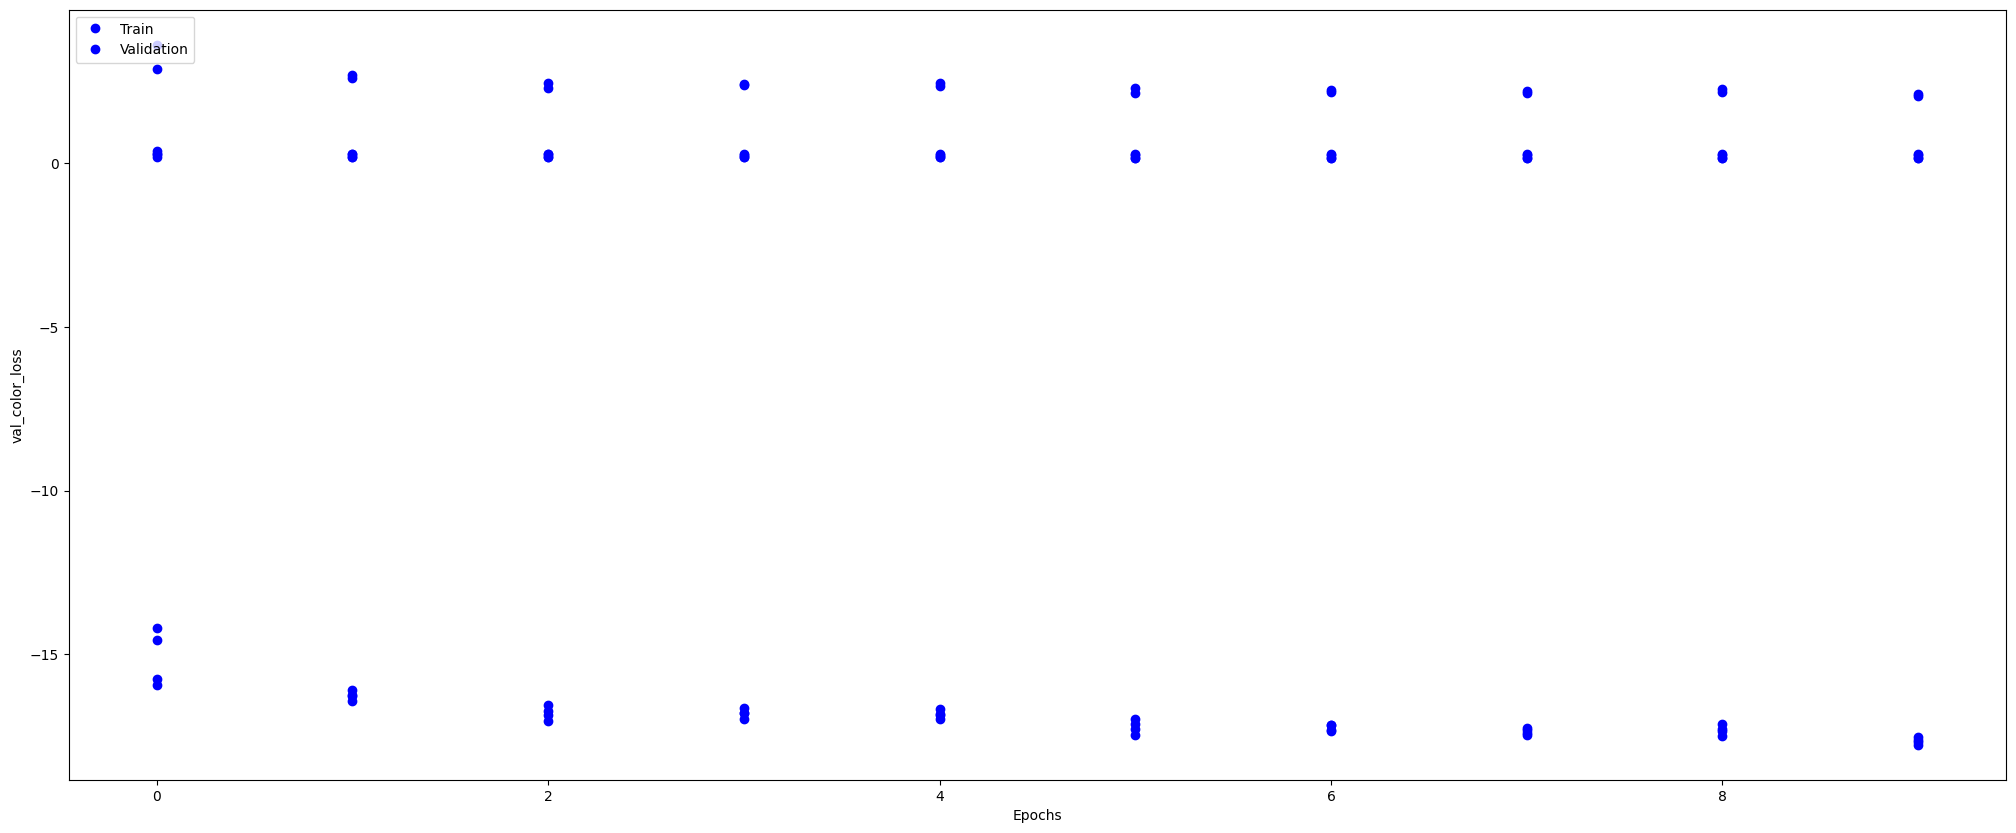

In [36]:
def plot_history(history):
    plt.clf()
    plt.figure(figsize=(25,10))
    
    metrics = list(history.keys())
    metrics = [metric for metric in metrics if "val" not in metric]
    
    data = 
    
    epochs = range(len(list(history.values())[0]))
    for metric, values in history.items():
        plt.plot(epochs, values, 'bo', label=f"Training {metric}")
#         plt.plot(epochs, val_value, 'b', label=f"Validation {metric}")
#         plt.title(f"Comparison of Training and Validation {metric}")
    plt.xlabel('Epochs')
    plt.ylabel(metric)
    plt.legend(['Train', 'Validation'], loc='upper left')
    plt.show()
    
plot_history(history.history)

In [ ]:
def evaluate(model, x_test, y_test):
    pass

In [31]:
plot_history(history.history)

TypeError: 'dict_values' object is not subscriptable

<Figure size 640x480 with 0 Axes>

<Figure size 2500x1000 with 0 Axes>

In [ ]:
evaluate(model, x_test, y_test)

## Visualize generated frames

In [21]:
predictions = model.predict([x_test[0:4][:, 0, :, :], x_test[0:4][:, 1, :, :]])

1/1 [==============================] - 0s 171ms/step


In [22]:
def visualize(true, predicted, surrounding):
    f, ax = plt.subplots(3, 2)
    f.set_size_inches(20, 20)
    
    ax[0][0].set_title("First frame")
    ax[0][0].set_xticks([])
    ax[0][0].set_yticks([])
    ax[0][0].imshow(surrounding[0])
    
    ax[1][0].set_title("Predicted frame")
    ax[1][0].set_xticks([])
    ax[1][0].set_yticks([])
    ax[1][0].imshow(predicted)
    
    ax[2][0].set_title("Second frame")
    ax[2][0].set_xticks([])
    ax[2][0].set_yticks([])
    ax[2][0].imshow(surrounding[1])
    
    ax[0][1].set_title("ABS(Predicted - Ground-truth)")
    ax[0][1].set_xticks([])
    ax[0][1].set_yticks([])
    ax[0][1].imshow(cv2.absdiff(predicted, true))
    
    ax[1][1].set_title("Ground-truth frame")
    ax[1][1].set_xticks([])
    ax[1][1].set_yticks([])
    ax[1][1].imshow(true)
    
    ax[2][1].set_title("ABS(Ground-truth - Predicted)")
    ax[2][1].set_xticks([])
    ax[2][1].set_yticks([])
    ax[2][1].imshow(cv2.absdiff(true, predicted))

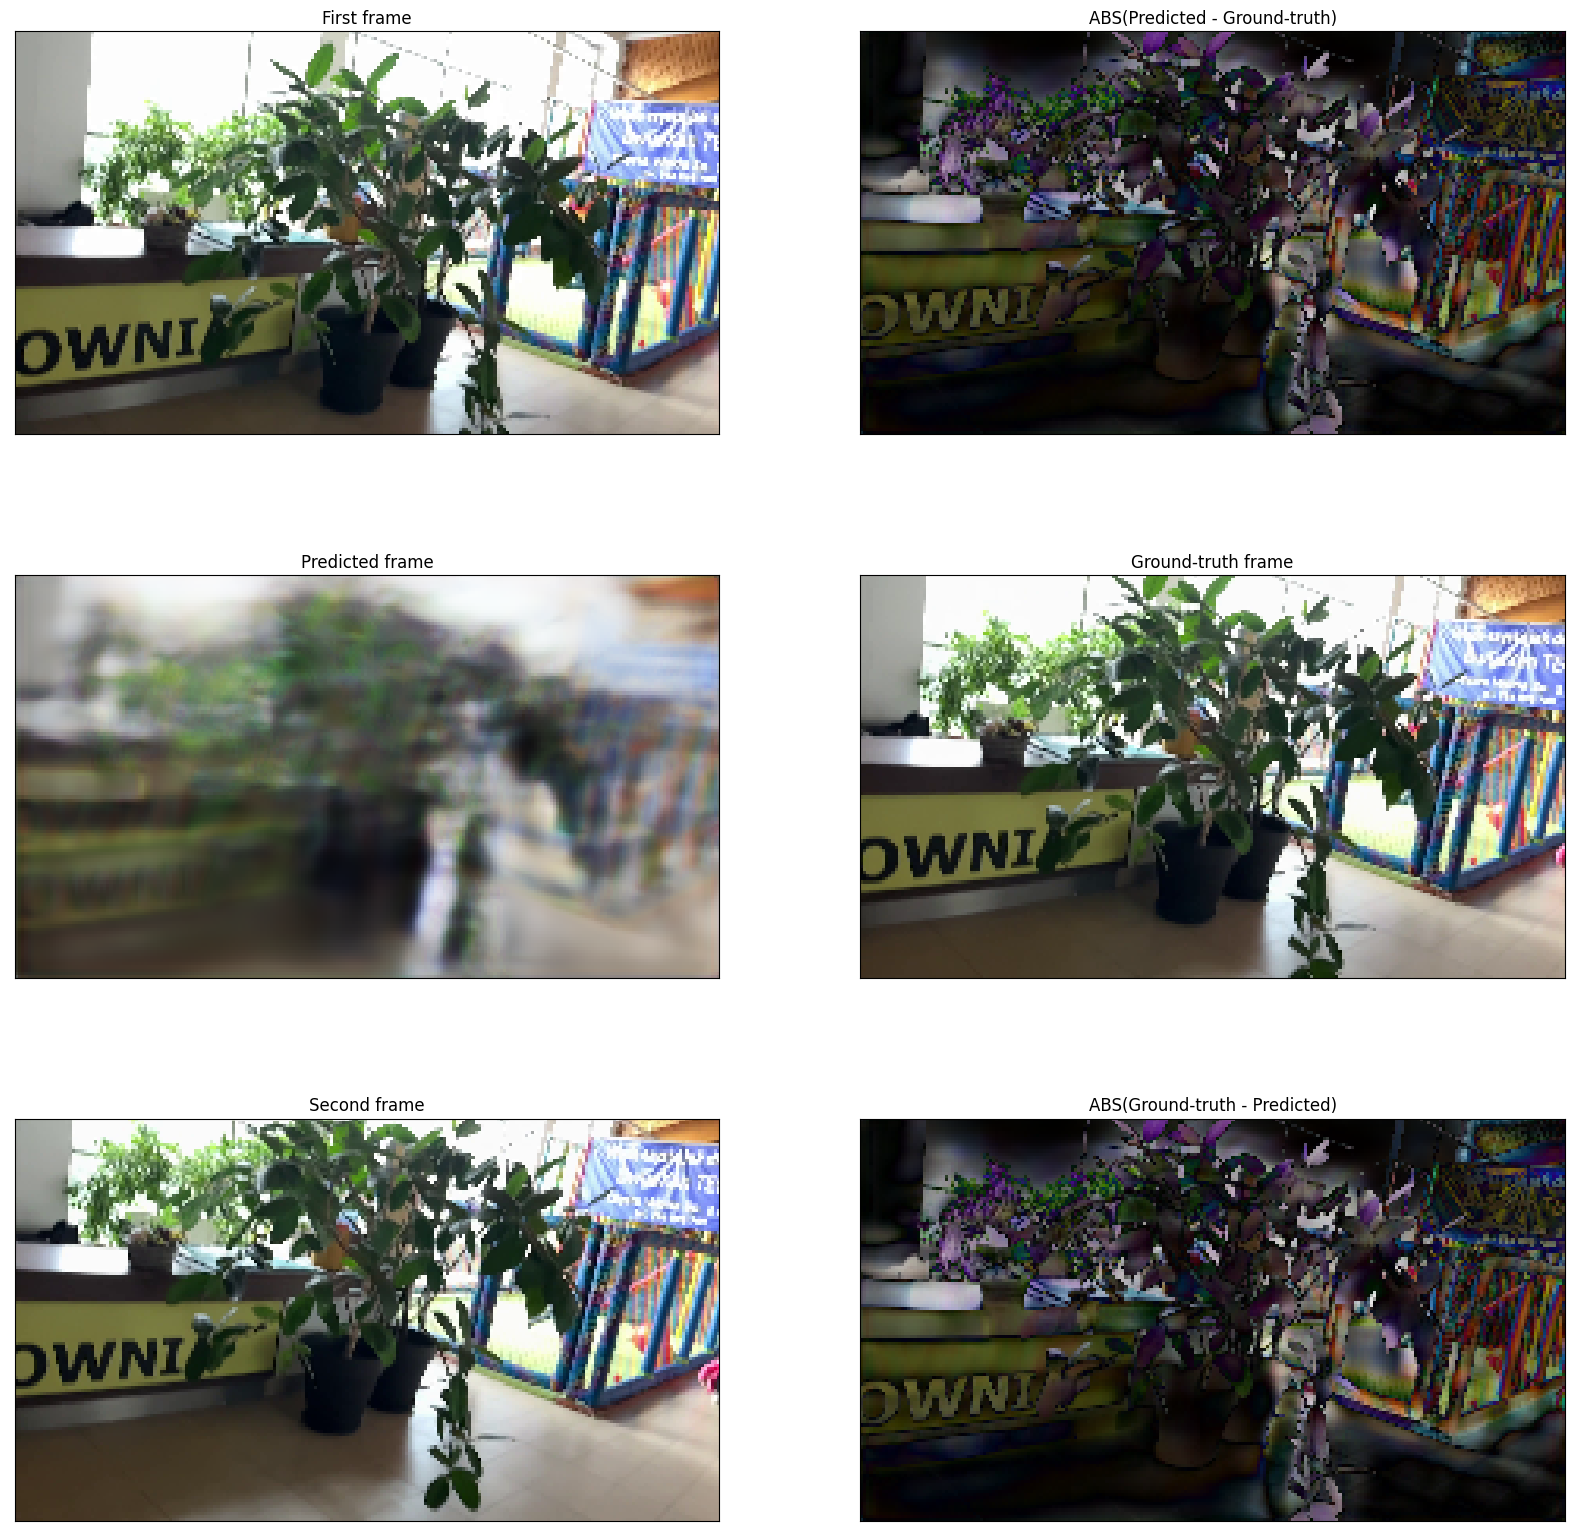

In [23]:
visualize(y_test[0], predictions[0], x_test[0])

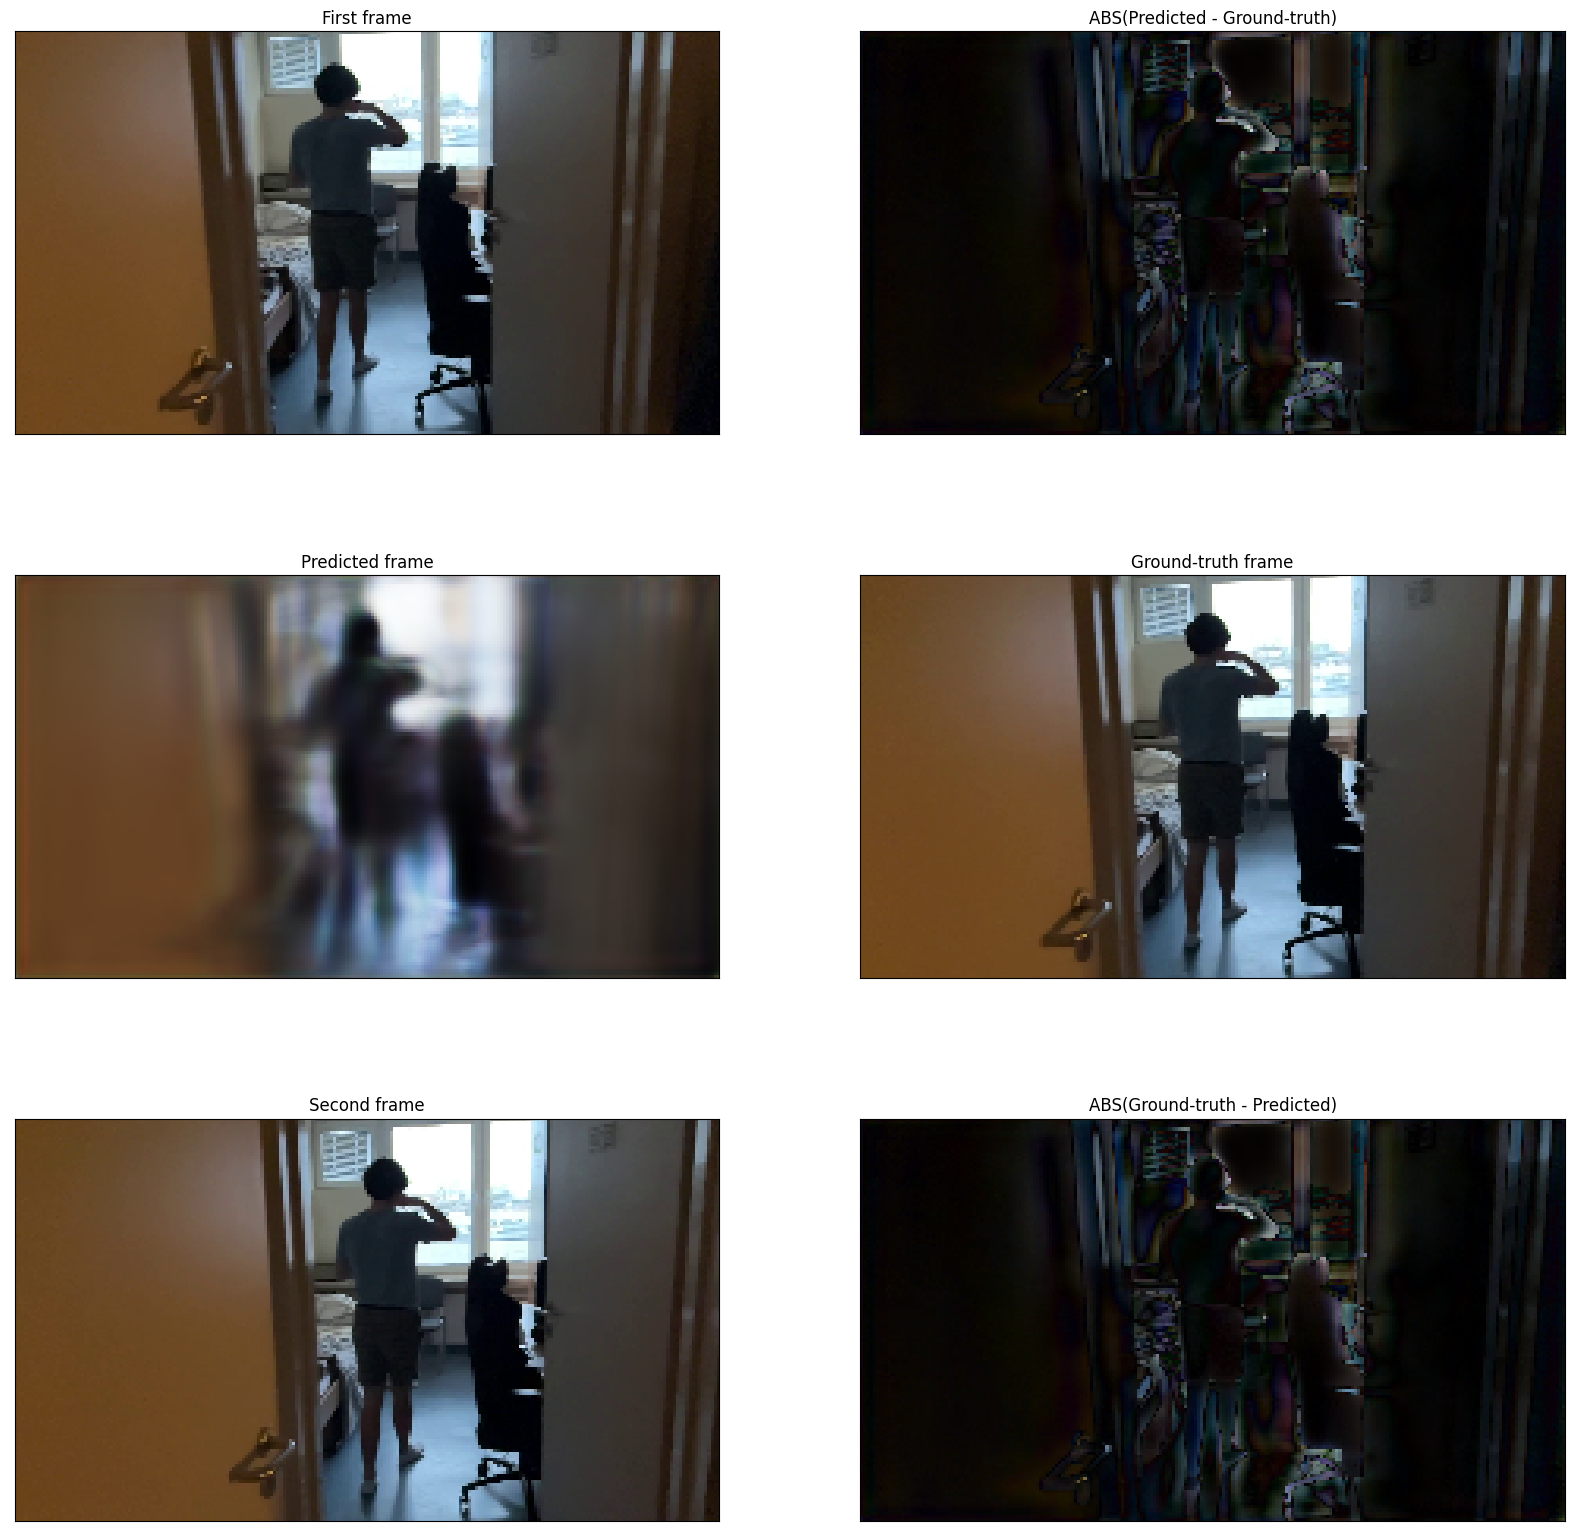

In [24]:
visualize(y_test[1], predictions[1], x_test[1])

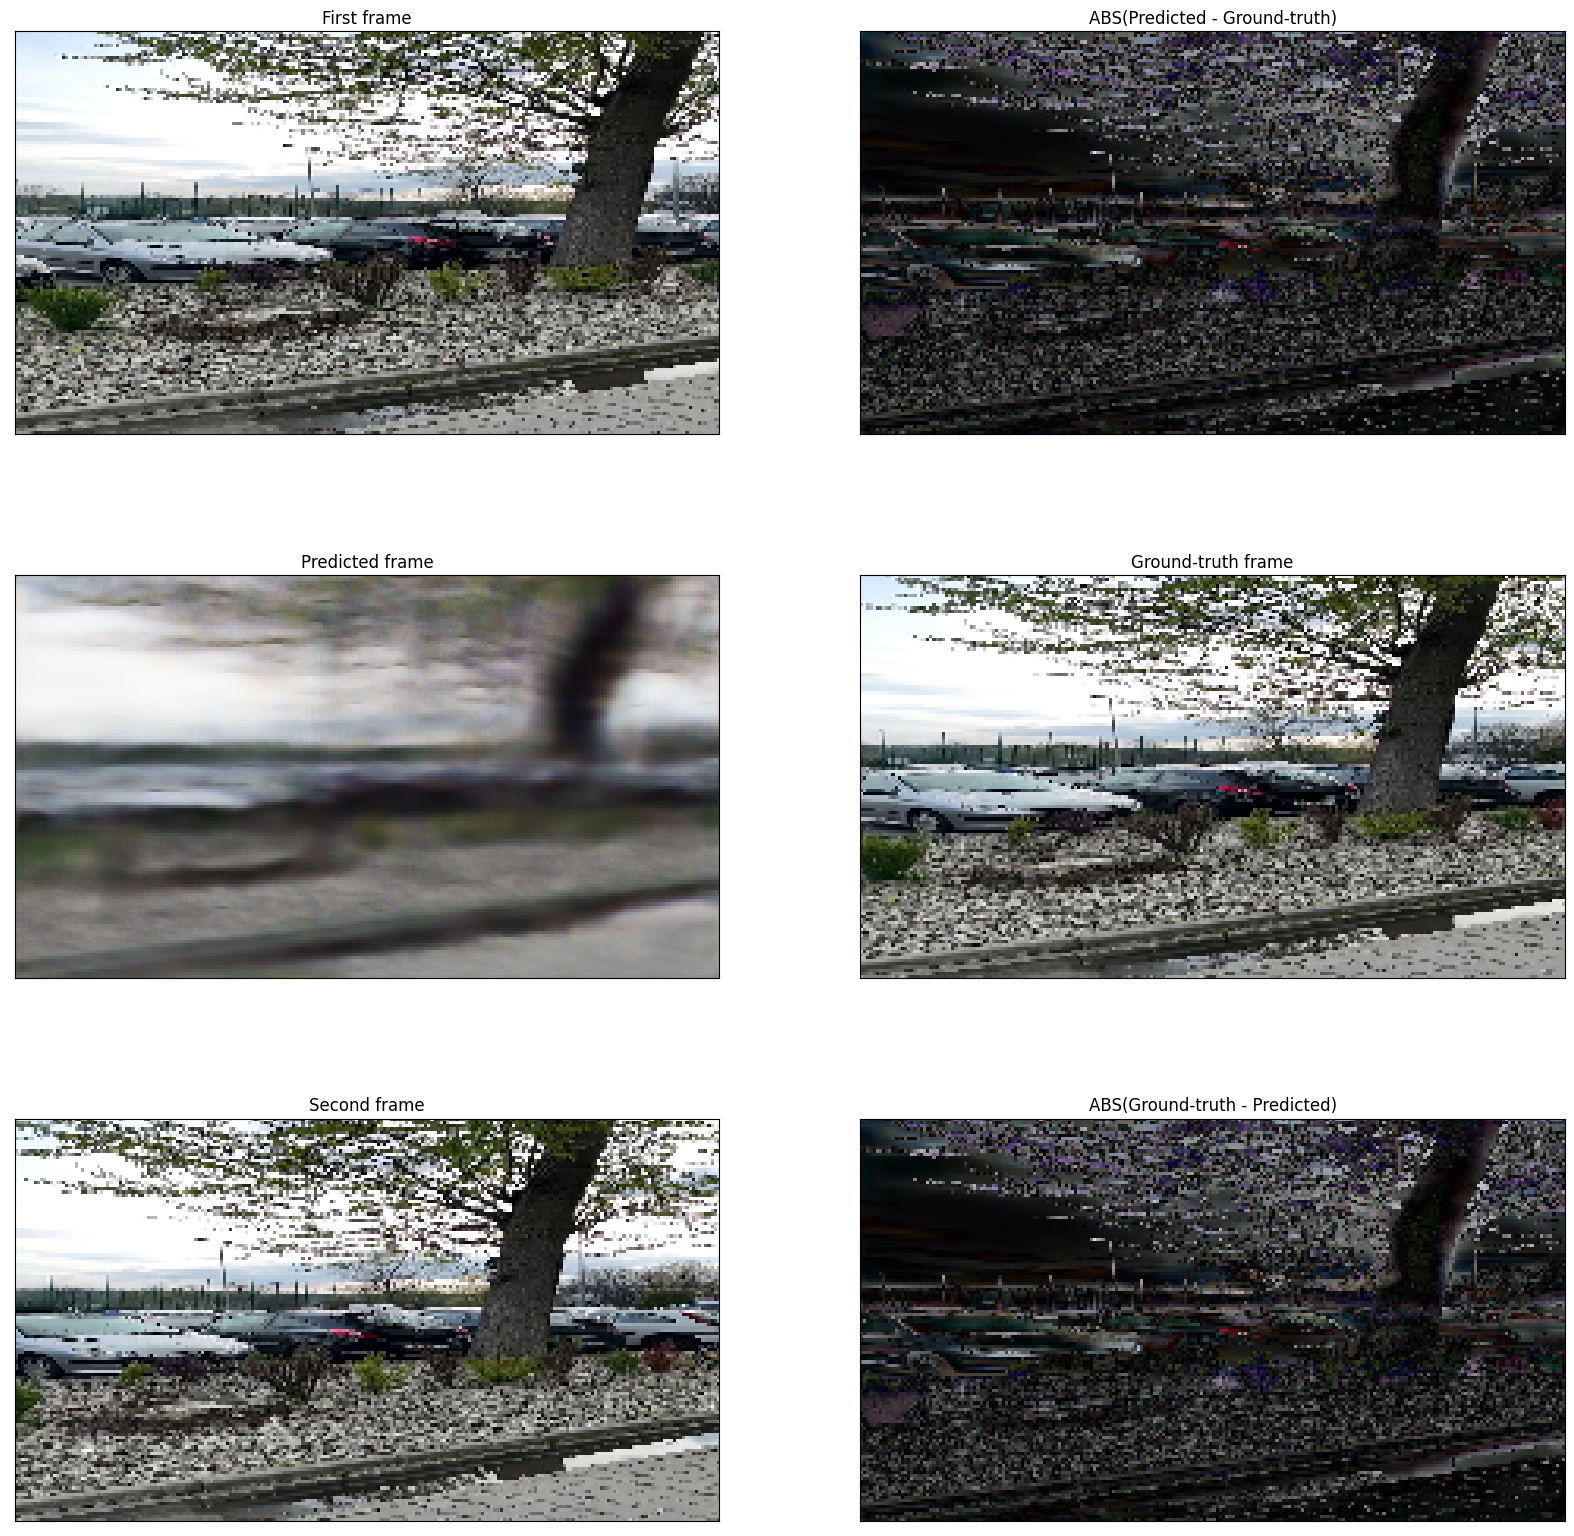

In [25]:
visualize(y_test[2], predictions[2], x_test[2])

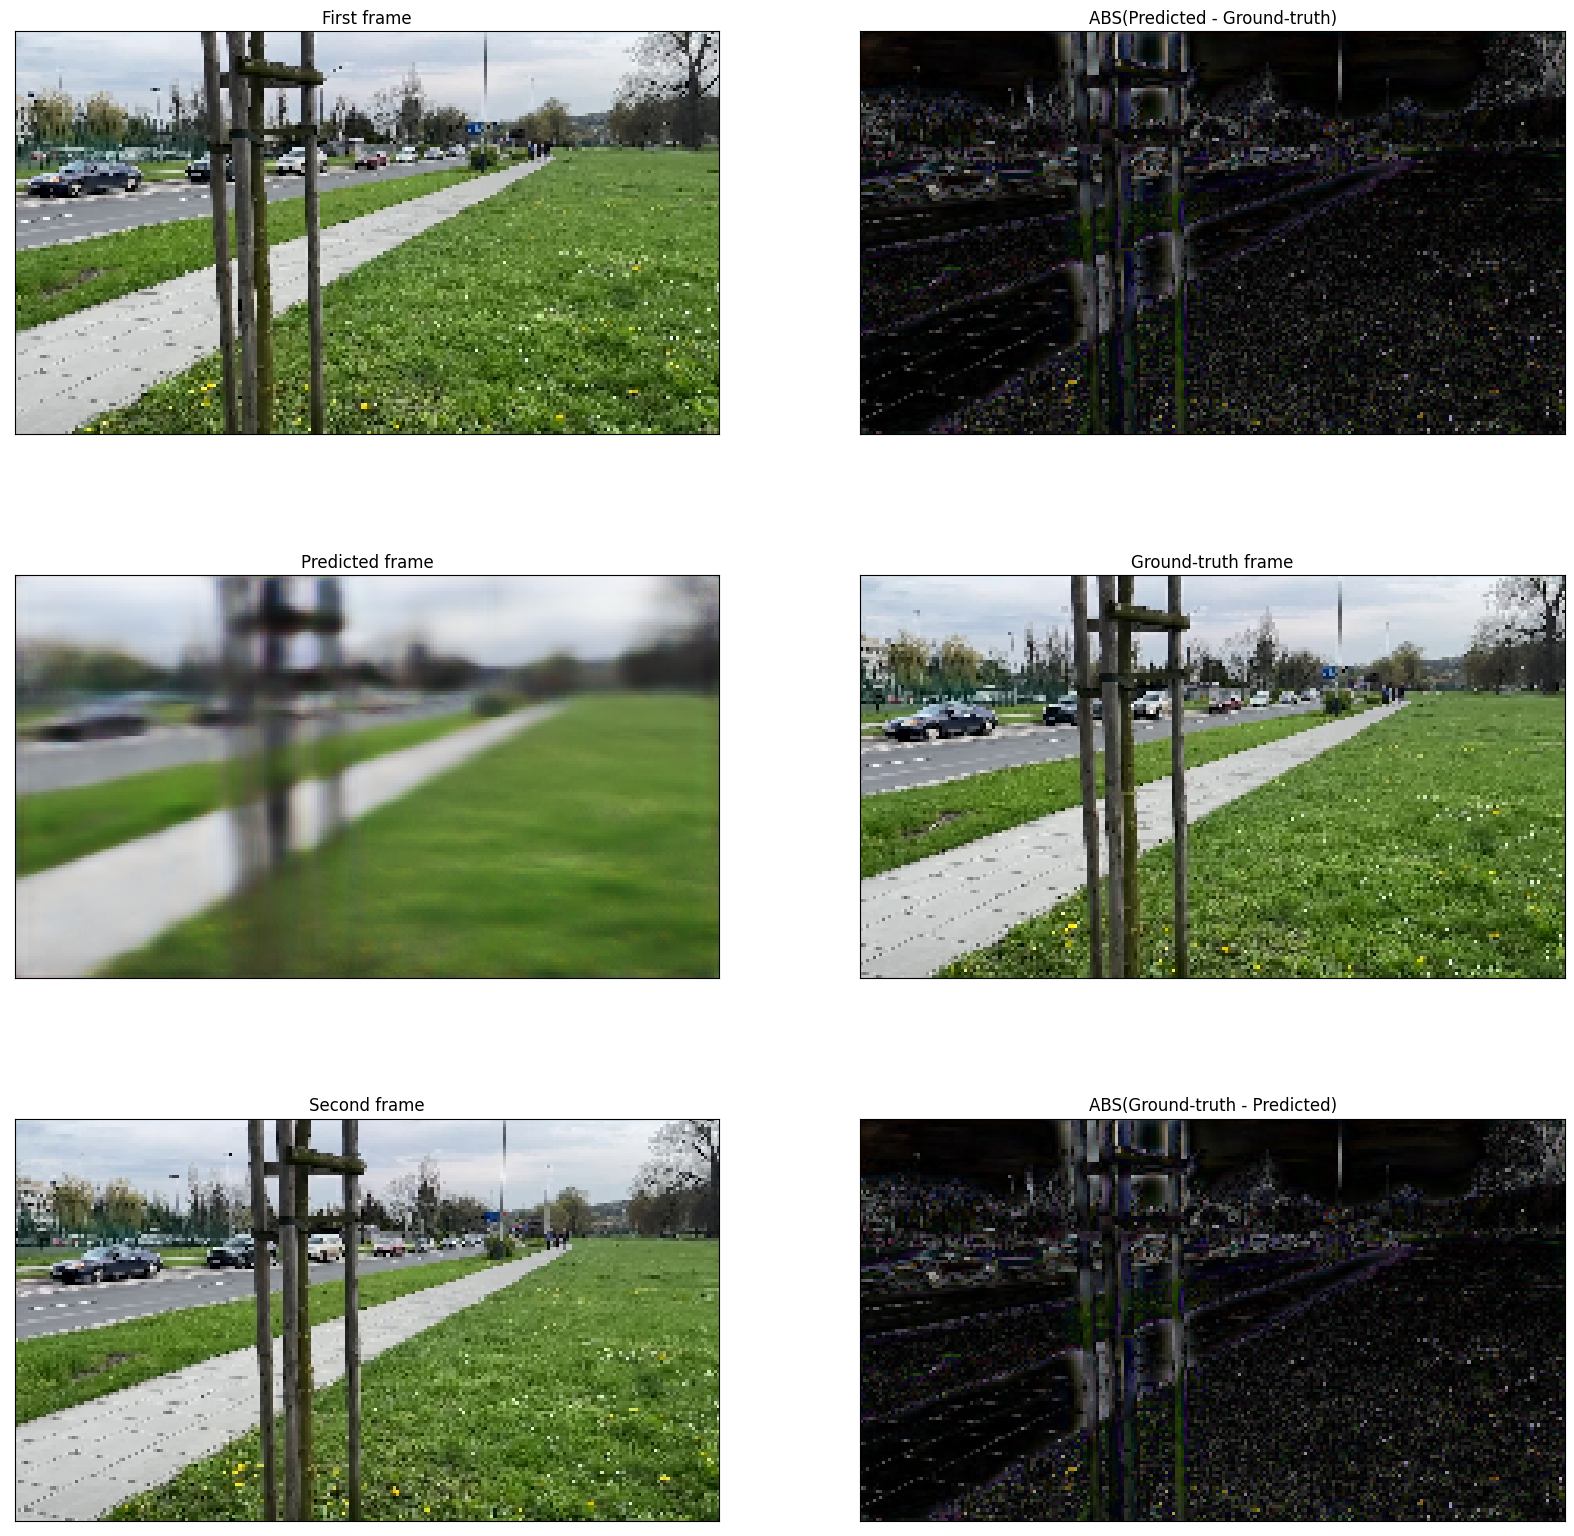

In [26]:
visualize(y_test[3], predictions[3], x_test[3])